# Rapport de projet numérique : Modélisation de la sortie d'une foule d'une salle

## Introduction

Nous avons eu comme but tout au long de ce projet numérique de simuler le comportement d'une foule de personne. En particulier, nous nous sommes attaché à simuler l'évacuation d'une salle, de concert par exemple, lors d'un mouvement de panique. Nous avons écrit un programme suffisement flexible pour nous permettre de changer certains paramètres (forme de la salle, nombre de personnes, rayon des personnes, présence d'obstacles) dans le but d'optimiser le temps d'évacuation de la salle.

Notre programme doit rendre compte des interactions à N corps, l'utilisation d'un outil numérique est donc absolument nécessaire pour répondre à notre problématique.

Nous présenterons et détaillerons dans ce rapport les points importants de notre programme, l'évolution des différents modèles que nous avons utilisé ainsi que les futurs améliorations que nous souhaiterions lui apporter.

A faire
intro + classe + personne/personne newton + mur

### Importation des librairies

In [8]:
%reset
import itertools
import random
import numpy.random as rd
import numpy as np
import matplotlib.animation as anim
import matplotlib.pyplot as plt
import os
from matplotlib.artist import Artist

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


### Variables d'entrées

Un nombre n de personnes seront placé aléatoirement dans une salle de taille x*y. On veillera à ce que deux personnes ne se superposent pas. Une personne sera représenté par une classe (détaillé par la suite) dans laquelle seront stocké sa position, sa vitesse, son rayon, la vitesse maximum qu'il peut atteindre et son numéro.

In [9]:
def initial(n,x,y,poteau,Sim_forces,vm=7,r=0.3):
    """
    Placement aléatoire de n personnes et affectation de leurs caractéristiques
    en prenant en compte les poteaux
    """
    #Placement aléatoire
    PosVi_tab=rd.rand(n,2,2)
    PosVi_tab[:,0,0]=PosVi_tab[:,0,0]*x+1
    PosVi_tab[:,0,1]=PosVi_tab[:,0,1]*y+1
    #Initalisation
    classe_tab=[]
    R=[]
    
    for num_part , PosVi in enumerate(PosVi_tab):
        #Rayon aléatoire
        ri=np.absolute(np.random.normal(r,0.05))
        #Vitesse maximale aléatoire
        v_max=np.absolute(np.random.normal(vm,0.8))
        R.append(ri)
        f=PosVi[1,0]+PosVi[1,1]
        
        if  f > 1 : 
            PosVi[1,0] , PosVi[1,1] = PosVi[1,0]/f , PosVi[1,1]/f
        
        classe_tab=classe_tab+[personne(PosVi[0,0],PosVi[0,1],PosVi[1,0]*v_max,PosVi[1,1]*v_max,ri,v_max,num_part)]
    
    classe_tab=np.array(classe_tab)
     
    #Ajout des personnes poteaux
    classe_tab = np.append(classe_tab,poteau)
    for part in poteau:
        PosVi_tab = np.append(PosVi_tab,[[part.x,part.y],[0,0]])
        PosVi_tab = PosVi_tab.reshape(len(classe_tab),2,2)
        R.append(part.r)
    
    #Replacement des personnes qui se superposent
    ls = np.arange(0,len(classe_tab))
    couple = list(itertools.combinations(ls,2))
    #a compte le nombre de superpositions, p le nombre d'itérations
    a=1 ; p=0
    
    while a!=0 and p<=100:
        
        a=0
        
        for ij in couple:
            
            i = ij[0]
            j = ij[1]
            #Test de superposition
            if classe_tab[i].superpose(classe_tab[j]):
                
                a=a+1
                classe_tab[i].x = rd.rand()*x+1
                classe_tab[i].y = rd.rand()*y+1
        p=p+1
    
    if p==101 :
        
        input('Trop de personnes dans la salle')
    for num_pers , pers in enumerate(classe_tab):
        
        PosVi_tab[num_pers,0,0]=pers.x
        PosVi_tab[num_pers,0,1]=pers.y
        
    a=0
    if Sim_forces: #Simulation Newtonienne
        a=0.2
    
    #Définition des murs
    def f1(pers) :
        return pers.y + (pers.r+a) >= 10

    def f2(pers) :
        return pers.y - (pers.r+a) <=0 

    def f3(pers) :
        return pers.x + (pers.r+a) >=10

    def f4(pers) :
        return pers.x - (pers.r+a) <=0

    vect1=np.array([1,0])

    vect2=np.array([1,0])

    vect3=np.array([0,1])

    vect4=np.array([0,1])

    #Définition des sorties
    sortie1 = np.array([[5,6],[0,0.5]])
    sortie2 = np.array([[5,6],[9.5,10]])

    mur_class_tab=np.array([mur(f1,vect1,sortie1),mur(f2,vect2),mur(f3,vect3),mur(f4,vect4)])

    return PosVi_tab , classe_tab , R , mur_class_tab

### Variables de sortie

Nous sauvegarderons à chaque pas de temps les positions et vitesses de chaque personne dans des fichiers text. Nous pourrons ainsi les relire après simulation pour faire l'animation des personnes ou bien utiliser des fichiers extérieurs de positions comme entrée pour calculer les positions des personnes à des pas de temps suivants.

In [10]:
def savefile(tab, name_pos='tab_pos.txt',name_vitesse='tab_vitesse.txt'):
    """
    Sauvegarde le np.array tab dans les fichier name_pos et name_vitesse
    """
    with open(name_pos,'a') as f_pos:
        f_pos.write("\n")
        pos = tab[:,0,:]
        np.savetxt(f_pos,pos)
        
    with open(name_vitesse,'a') as f_vitesse:
        f_vitesse.write("\n")
        vitesse = tab[:,1,:]
        np.savetxt(f_vitesse,vitesse)
        

def readfile(name_pos='tab_pos.txt',name_vitesse='tab_vitesse.txt'):
    """
    Retourne les tableaux contenus dans les tab.txt, sauvegardés avec savefile
    """
    tab_pos = np.loadtxt(name_pos)
    tab_vitesse = np.loadtxt(name_vitesse)
    
    return tab_pos , tab_vitesse

### L'animation

In [11]:
def animate(i,tab_pos,ax,R,n_liste,L,n_obstacle):
    """
    Fonction qui retire les persones affiché au temps t-dt et affiche celle au temps t
    """
    if i!=0 :
        Artist.set_visible(L[i-1], False)
    Artist.set_visible(L[i], True)
    #Retire les anciens objets correspondant aux personnes au temps t-dt
    for obj in ax.findobj(match = type(plt.Circle(1, 1))):
        
        obj.remove()
    #Extrait les positions des personnes à afficher
    n_ini = int(np.sum(n_liste[0:i])) + i*n_obstacle
    M=tab_pos[n_ini:n_ini+n_liste[i]+n_obstacle]
    #Affiche un cercle pour représenter la personne. Sont centre est la postion de la
    #personne et son rayon est le rayon de la personne.
    for u , j in enumerate(M):
        if u < len(M)-n_obstacle:
            ax.add_artist(plt.Circle(j,radius=R[i][u],fill=False))
        else :
            ax.add_artist(plt.Circle(j,radius=R[i][u],fill=True))
        
    return

## I. Les interactions de personne à personne

Les intéractions entre les personnes constituent le coeur de la modélisation de celles-ci. Plusieurs modèles ont été envisagés et testés nous en présenterons ici deux. Pour coder les intéractions entre les personnes nous nous sommes fortement appuyés sur une classe d'objet : la classe personne. En voici un détail explicite.

Nous avons choisi de nous appuyer sur une classe pour les personnes par soucis de simplification de lecture du code et parcequ'il était aisé de définir l'ensemble des personnes par un comportement commun.

### A. Définition de la classe personne

La classe personne permet de définir une personne à partir de sa position (x,y), sa vitesse (vx,vy), son rayon (r), sa vitesse maximum (v_max), et le numéro de celle-ci (num). Viennent ensuite quatres méthodes : distance, superpose, distance_sortie et calcul_vect_per.

Détail des méthodes :

- distance() mesure la distance entre la personne et une autre personne. Elle renvoie la distance radiale, la composante suivant x et la composante suivant y

- superpose() permet de verifier si deux particules se superpose. La fonction renvoie True si les deux particules se superposent

- distances_sortie() permet de mesurer la distance à chaque sortie de la personne. Nous verront par la suite que la personne doit se diriger vers la sortie qui lui est la plus proche.

- calcul_vect_per() calcule le vecteur perpendiculaire au vecteur reliant les deux personnes. Nous utiliserons cette méthode par la suite pour gérer les colisions entre les personnes dans le cas de notre modèle non conservatif.

In [12]:
class personne:
    
    def __init__(self,x,y,vx,vy,r,v_max,num):
        """
        
        Définition de la personne.
        
        Parameters
        ----------
        x : Float
            Coordonée x de la position de la personne.
        y : Float
            Coordonée y de la position de la personne.
        vx : Float
            Coordonée x de la vitesse de la personnes.
        vy : Float
            Coordonée y  de la vitesse de la personne.
        r : Float
            Rayon de la personne (celle-ci à une forme de cercle vu du dessus).
        v_max : Float
            Norme de la vitesse maximale atteignable par la personne.
        num : Int
            Numéro de la personne.

        Returns
        -------
        None.

        """
        self.x = x
        self.y = y
        self.vx = vx
        self.vy = vy
        self.r = r
        self.v_max = v_max
        self.num = num
        
    def distance(self,autre):
        """Retourne la distance entre la personne et une autre, sur l'axe x
        et y"""
        dx = self.x - autre.x
        dy = self.y - autre.y
        return np.sqrt(dx**2+dy**2),dx,dy
    
    def superpose(self,autre):
        """Retourne True si les deux personnes se superposent"""
        
        answer = self.distance(autre)[0] < self.r + autre.r
        return answer
    
    def distances_sortie(self,mur_class_tab):
    
        """
        Retourne la distance et la direction d'une personne à chaque sortie.
        """
        
        d = [] ; v = []
        for num_mur, mur in enumerate(mur_class_tab):
            #Test si le mur contient une sortie
            if np.any(mur.sortie != None) == True:
                
                (vecteur,distance) = mur.d_mur(self)
                d.append(distance)  ; v.append(vecteur)
                
        d = np.array(d) ; v=np.array(v)
        
        return d , v

    def calcul_vect_per(self , vect_par):
        
        """Calcul le vecteur perpendicualaire à la direction entre deux personnes
        dont le produit scalaire avec le vecteur vitesse de la personne dont on modifie 
        la vitesse est positif"""
        #Vecteur vitesse
        v=np.array([self.vx , self.vy])
        
        #éviter une division par 0
        if vect_par[1] == 0 :
            
            vect_1 = np.array([0,1])
            vect_2 = np.array([0,-1])
        
        else:
            
            #Calcul des deux vecteurs : dans les deux sens opposé
            vect_1 = np.array([1,-(vect_par[0]/vect_par[1])])
            vect_2 = np.array([-1,vect_par[0]/vect_par[1]])
            #Normalisation des vecteurs
            vect_1 = vect_1 / np.linalg.norm(vect_1)
            vect_2 = vect_2 / np.linalg.norm(vect_2)
        
        #Verification du produit scalaire pour connaitre le sens du vecteur à retourner
        prod_sca_1 = np.vdot(vect_1 , v)
        
        if prod_sca_1 >= 0 :
            
            return vect_1
        
        return vect_2

Finalement, nous avons ajouté une fonction change_v_part() qui permet de changer la vitesse de la particule si la particule rencontre un obstacle : un mur ou une autre personne. En cas de contact avec un obstacle, la composante perpendiculaire à l'obstacle de la vitesse de la particule sera alors supprimée.

In [13]:
def change_v_part(vect,pers,PosVi):
    """
    Change la vitesse la particule en lui supprimant sa composante 
    perpendiculaire à un obstacle (mur ou autre peronne).
    """
    #Vecteur vitesse de la personne
    v = np.array([pers.vx , pers.vy])
    #Vecteur vitesse au temps précédent de la personne
    v_prec = PosVi[1,:]
    #Vecteur moyen entre le temps actuel et précédent
    v_moy = (1/2)*( v_prec + v )
    #Produit scalaire entre la vitesse de la personne et le vecteur de l'obstacle
    prod_sca = np.vdot(vect , v )
    #Produit scalaire entre la vitesse moyenne de la personne et le vecteur de l'obstacle
    prod_sca_moy = np.vdot(vect , v_moy )
    #Nouvelle vitesse et nouvelle vitesse moyenne en supprimant la composante perpendiculaire à l'obstacle
    v_nouv = prod_sca * vect
    v_nouv_moy = prod_sca_moy * vect
    
    return v_nouv , v_nouv_moy

### B. Modèle newtonien d'intéraction personne à personne

La première façon de modéliser les intéractions entre personnes est de considérer des forces entre les personnes. Dans ce cas les personnes sont modélisés comme des particules subissant des intéractions. Nous appliquons ensuite les lois de Newton pour calculer la position des particules au temps suivant.

Dans le détail, les personnes sont modélisé comme des particules, chacune subissant une force répulsive des autres. 

- Nous allons donc définir la force d'interaction entre particules. Cette force est une force répulsive inversement proportionnelle à la distance entre les personnes à la puissance 7. Nous avions pensé dans un premier temps à ce que cette force soit proportionnelle au produit des masses des deux particules mais cela ne rendait pas compte de ce que nous souhaitions simuler : une foule de personne et non pas un mouvement de particules de gaz. Nous avons implémenté le fait que la force d'interaction entre particule avait un seuil de détection au-dela duquel la force est nulle. Cela permet de réduire le temps de calcul nécessaire.

- Nous créons un tableau des forces recensant les forces entre chaque particule. Cette matrice est donc antisymétrique car F_A/B = - F_B/A. Cette propriété réduit encore le temps de calcul car il n'est ainsi pas nécéssaire de parcourir l'ensemble des couples possibles parmis les particules : le couple (i;j) aura la même force d'interaction à un signe près que le couple (j;i).

- Nous créons aussi un tableau d'intéraction entre les particules et les murs. Chaque particule étant attirées par la sortie la plus proche d'elle. La force d'attraction de la sortie est détaillé lors du traitement de la classe mur.

- Finalement, à partir du tableau de la somme des forces s'appliquant à chaque particules nous calculons l'accélération que subit chaque particule. Cela nous permettera par la suite en se basant sur les lois de Newton de calculer la trajectoire des particules.

In [14]:
def acceleration(sumF_tab,classe_tab,n):
    
    """Calcul un tableau contenant les accélérations de chaque particules
selon chaque axes. La forme du tableau est donc (n,2)"""
    #Initialisation
    a_tab= np.zeros((n,2))
    #Remplissage
    for i in range(0,n):
        a_tab[i,:] = sumF_tab[i,:]
        
    return a_tab

def force(part1,part2,detection):
    """ 
    Retourne la force de repulsion entre la particule et une autre.
    Les particule en dehors du rayon de detection sont negligées
    """
    #La particule est dans le champ de detection
    if part1.distance(part2)[0] < detection:
        
        if part1.distance(part2)[1] == 0: #Eviter une division par 0
            Fx = 0
        else:
            #Force répulsive en 1/d^7, composante en x
            Fx = -1/part1.distance(part2)[1]**7 
        
        
        #Composante en y
        if part1.distance(part2)[2] == 0: #Eviter une division par 0
            Fy = 0
        else:
            Fy = -1/part1.distance(part2)[2]**7 
        
        #Vecteur force
        F = np.array([Fx,Fy])
    
    #La particule est hors du champ de detection, la force est donc nulle
    else :
        F = np.zeros(2)
    
    #Norme de la force
    norm_F=np.linalg.norm(F)
    
    #Pour maximiser la force
    if norm_F>10:
        
        F=F/norm_F
        
    return F

def pos_ini(PosVi_tab,dt):
    pos_ini_tab = np.zeros(np.shape(PosVi_tab))
    pos_ini_tab[:,0,:] = PosVi_tab[:,0,:]-dt*PosVi_tab[:,1,:]
    return pos_ini_tab

def tab_force(classe_tab,detection):
    """
    Retourne le tableau de force entre N particules = len(class_tab). 
    class_tab est le tableau des objets particules. 
    detection est le seuil de detection pour la force
    """
    #Initialisation
    F_tab_x = np.zeros((len(classe_tab),len(classe_tab)))
    F_tab_y = np.zeros((len(classe_tab),len(classe_tab)))
    #Liste pour faire des couples de particules
    ls = np.arange(0,len(classe_tab))
    #Faire toutes les combinaisons possibles
    couple = list(itertools.combinations(ls,2))
    
    #Tester tous les couples  et remplissage du tableau
    for ij in couple:
        i = ij[0]
        j = ij[1]
        #Composantes en x
        F_tab_x[i,j] = force(classe_tab[i],classe_tab[j],detection)[0]
        # F_A/B = -F_B/A
        F_tab_x[j,i] = - F_tab_x[i,j]
        
        #Composantes en y
        F_tab_y[i,j] = force(classe_tab[i],classe_tab[j],detection)[1]
        # F_A/B = -F_B/A
        F_tab_y[j,i] = - F_tab_y[i,j]
        
    #Tableau final
    F_tab = np.array([F_tab_x,F_tab_y])
        
    return F_tab

def tab_force_mur(mur_class_tab,classe_tab):
    """
    Retourne le tableau de force sur chaque particule des mur
    tableau de taille (nbr_part,2)
    Si la part est au centre, elle doit prendre la sortie la plus proche
    """
    
    #Initialisation
    F_tab = np.zeros([len(classe_tab),2])
    
    #Test sur toutes les particules
    for num_part, part in enumerate(classe_tab):
        #Distance au mur et mur associé
        d = []
        #Test sur tous les murs
        for num_mur, mur in enumerate(mur_class_tab):
            #Si le mur contient une sortie
            if np.any(mur.sortie != None) == True:
                #Position de la sortie
                pos_sortie = [np.mean(mur.sortie[0]) , np.mean(mur.sortie[1])]
                #Vecteur entre la sortie et la particule
                v = np.array([pos_sortie[0]-part.x,pos_sortie[1]-part.y])
                #Distance entre la particule et la sortie
                distance = np.linalg.norm(v)
                #Ajout au tableau
                d.append([distance,mur])
                
        #Conversion avec le module numpy pour plus de rapidité lors de calculs        
        d = np.array(d)
        #Indice de la sortie la plus proche
        i_min = np.argmin(d,axis=0)
        
        #Mur le plus proche
        mur_proche = d[i_min[0]][1]
        
        #Force d'attraction de la sortie la plus proche
        F = np.array([mur_proche.force_exit(part)[0],mur_proche.force_exit(part)[1]])
        F_tab[num_part] = F
                
        
    return F_tab

Le problème du modèle newtonien d'intéraction est qu'il est conservatif. On pourra observer lors de sa mise en oeuvre que cela ne délivre pas une simulation fidèle. En effet, les personnes se comportent comme des particules d'un gaz soumis au champ gravitationnel terrestre. Cela signifie que même si elles sont attirées vers le bas le caractère conservatif garantis que si une particule descend : une autre remonte. Celles-ci ne s'agglomère pas vers le bas or c'est ce phénomène que nous souhaitons observer.

L'avantage cependant de cette méthode est que le temps de calcul est assez limité car plusieurs optimisations ont été mis en place.

Le modèle Newtonien n'étant pas satisfaisant pour ce que nous voulions modéliser, nous nous sommes tourner vers un modèle non conservatif. Certes moins basé sur des phénomène physique mais plus réaliste pour ce que nous voulions faire. 

### C. Modèle non-conservatif d'intéraction personne à personne

Nous avons vu les limites du modèle newtonien d'interaction. Pour régler ces problèmes nous avons considérer un modèle non conservatif. Dans celui-ci, si deux personnes vont se rentrer dedans alors celle qui s'approche de l'autre (ou les deux si elles s'approchent mutuellement) va perdre la composante de sa vitesse qui est colinéaire au vecteur allant d'une personne à l'autre. Un schéma vaut mieux que des explications.

In [15]:
def change_v_part(vect,pers,PosVi):
        """
        Change la vitesse la particule en lui supprimant sa composante 
        perpendiculaire à un obstacle (mur ou autre peronne).
        """
        
        v = np.array([pers.vx , pers.vy])
        v_prec = PosVi[1,:]
        v_moy = (1/2)*( v_prec + v )
        prod_sca = np.vdot(vect , v )
        prod_sca_moy = np.vdot(vect , v_moy )
        v_nouv = prod_sca * vect
        v_nouv_moy = prod_sca_moy * vect
        
        return v_nouv , v_nouv_moy

## II. Les murs et les sorties

Les intéractions murs/persones sont relativement simple. En effet le mur ne peut pas être modifié par la personne et la personne ne peut pas le franchir. Il y a cependant plusieurs façons de modéliser cette intéraction. Il sera question ici du modèle choisi. Ce sont dans les murs que se trouvent les sorties physiquement parlant mais aussi dans notre programme car les sorties sont un paramètre de la classe mur qui sera explicité ici. L'intéraction entre les personnes et la sortie est la dernière intéraction à traiter pour finaliser notre modèle.

### A. La classe mur

Nous avons défini un mur par quelques paramètres simples :

- Sa fonction : la fonction déterminant le domaine de l'espace qui est exclue par le mur
- Son vecteur qui est parallèle au mur
- Sa sortie, ou non, qui indique la position de la sortie : un interval de l'espace.

La classe mur est ensuite associé à plusieurs méthodes :

- collision() qui détecte si il y a collision entre une personne et le mur.
- d_mur() qui mesure la distance entre la personne et le mur.
- handle_part_exit() qui détecte si une personne sort ou non de l'enceinte des murs.
- force_exit() qui retourne la force d'attraction de la sortie sur les particules.

In [16]:
class mur:
    def __init__(self,f,vect,sortie = None):
        """
        f est la fonction représentative en fonction de x et y du mur
        vect est le vecteur directeur du mur
        sortie est de la forme np.array([[xmin,xmax],[ymin,ymax]])
        """
        self.f = f
        self.vect=vect
        self.sortie = sortie
        
    def collision(self,pers):
        """
        Retourne true si la personne dépasse du mur
        """
        answer = self.f(pers)
        
        return answer
    
    def d_mur(self,particule):
        """
        Mesure la distance entre la particule et la sortie et le vecteur les rejoignant.
        """
        #Position de la sortie
        pos_sortie = [np.mean(self.sortie[0]) , np.mean(self.sortie[1])]
        #Vecteur reliant la personne à la sortie
        v = np.array([pos_sortie[0]-particule.x,pos_sortie[1]-particule.y])
        #Distance entre la personne et la sortie
        norm_v = np.linalg.norm(v)
        
        return v , norm_v
    
    def handle_part_exit(self,part):
        """
        Retourne True si la particule sort
        """
        #Si le mur contient une sortie
        if np.all(self.sortie != None):
            #et si la particule sort
            if part.x >= self.sortie[0,0] and part.x <= self.sortie[0,1] and part.y >= self.sortie[1,0] and part.y <= self.sortie[1,1]:
                return True
        else: return False
    
    def force_exit(self,particule):
        """
        Retourne la force qu'exerce la sortie sur une particule
        """
        
        #Position de la sortie
        pos_sortie = [np.mean(self.sortie[0]) , np.mean(self.sortie[1])]
        #Vecteur reliant la personne à la sortie
        v = np.array([pos_sortie[0]-particule.x,pos_sortie[1]-particule.y])
        #Distance à la sortie
        norm_v = np.linalg.norm(v)
        
        #Si la distance est nulle, la particule n'est plus attirée car elle sort
        if norm_v == 0:
            F = np.array([0,0])
            
        #Sinon elle est attiré vers la sortie avec une force de norme 10
        else :
            F = 10*v/norm_v
            
        return F

### B. L'intéraction  mur à personne

Voir ligne 42 du code de la partie III.A. et ligne 29 du code de la partie III.B.

- On détecte si la personne est en interaction avec le mur : la personne touche-t-elle le mur ?
- On change la vitesse de la particule en utilisant la fonction change_v_part() détaillée plus haut. Ce modèle est non conservatif.

### C. L'intéraction mur à sortie

Nous calculons ici la vitesse de chaque personne par rapport à la sortie la plus proche.

In [17]:
def v_sortie(classe_tab,mur_class_tab,n):
    
    """
    Calcul les vitesses de chaque personnes par rapport à la sortie la plus proche.
    """
    #Initialisation
    V=np.zeros((n,2))
    
    #Parcours de toutes les particules
    for num_part, part in enumerate(classe_tab):
        
        #Distance entre la particule et tout les murs
        d,v= part.distances_sortie(mur_class_tab)
        #Mur le plus proche
        i_min=np.argmin(d)
        #Distance au mur le plus proche
        d=d[i_min]
        #Vitesse par rapport au mur le plus proche
        v=(v[i_min,:]*part.v_max)/d
        #Remplissage du tableau
        V[num_part] = v
    
    return V

## III. L'intégrateur

### A. L'intégrateur pour le modèle newtonien d'intéraction personne à personne

In [18]:
def change_posvi_forces(PosVi_tab,PosViprec_tab,classe_tab,mur_class_tab, dt,n):
    
    """Calcul les vitesses des particules au nouveau pas de temps"""
    
    #Tableau des forces entre particules
    F_tab_part = tab_force(classe_tab,100)
    #Somme des forces s'appliquant à une particule
    sumF_tab=np.reshape(np.sum(F_tab_part,axis=2),(n,2))
    
    #Tableau des forces de sortie
    F_tab_mur = tab_force_mur(mur_class_tab,classe_tab)
    
    #Somme des forces totales s'appliquant à la particule
    sumF_tab = sumF_tab + F_tab_mur
    
    #Calcul de l'accélération de la particule
    a_tab=acceleration(sumF_tab,classe_tab,n)
    #Calcul de la vitesse à partir de la vitesse précédente et de l'accélération
    V=PosViprec_tab[:,1,:] + 2*a_tab*dt
    Vtot=np.sqrt(V[:,0]**2+V[:,1]**2)
    
    for i , j in enumerate(V) :
        
        vm=classe_tab[i].v_max
        Vtoti=Vtot[i]
        
        #La particule a dépassé sa vitesse max
        if Vtoti > vm :
            
           V[i,:]=(j/Vtoti)*vm
           
    #Vitesse moyenne
    Vmoy = (1/2)*(PosVi_tab[:,1,:]+V)
        
    for i , j in enumerate(classe_tab) :
        
        j.vx = V[i,0]
        j.vy = V[i,1]
        
        for k in mur_class_tab :
            
           #Collision avec un mur 
           if k.collision(j):
              
              V[i,:] , Vmoy[i,:] =change_v_part(k.vect , j , PosVi_tab[i,:,:])
    
    #Calcul de la position
    X=PosVi_tab[:,0,:]+dt*Vmoy
    X , V = np.reshape(X,(n,1,2)) , np.reshape(V,(n,1,2))
    PosViprec_tab , PosVi_tab = PosVi_tab , np.concatenate((X,V),axis=1)
    
    for i , j in enumerate(classe_tab):
        #Mise à jour des position et vitesse de toutes les particules
        j.x= PosVi_tab[i,0,0]
        j.y= PosVi_tab[i,0,1]
        j.vx= PosVi_tab[i,1,0]
        j.vy= PosVi_tab[i,1,1]
        
    return PosViprec_tab , PosVi_tab

### B. L'intégrateur pour le modèle non-conservatif d'intéraction personne à personne

In [19]:
def change_posvi(PosVi_tab,classe_tab,mur_class_tab,dt,n):
    
    """Calcul les vitesses et les positions des personnes au nouveau pas de temps"""
    
    #Calcul naif des vitesses et positions au pas de temps suivant
    V=v_sortie(classe_tab,mur_class_tab,n)
    V_moy = (1/2)*(PosVi_tab[:,1,:]+V)
    X=PosVi_tab[:,0,:]+dt*V_moy
    
    #Définition des couples de particules en intéraction
    ls = np.arange(0,len(classe_tab))
    couple = list(itertools.permutations(ls,2))
    
    #Mise à jour des vitesses et positions dans la classe personne
    for num_pers , pers in enumerate(classe_tab):
        
        pers.x= X[num_pers,0]
        pers.y= X[num_pers,1]
        pers.vx= V[num_pers,0]
        pers.vy= V[num_pers,1]
    
    #Décompte des superpositions et du nombre de pas de calcul
    a=1 ; p=0 ; p_max = max(5,int(n/2))
    
    while a!=0 and p<=p_max:
        
        a=0
        
        #Intéraction avec les murs
        for num_pers , pers in enumerate(classe_tab):
            
            c=0
            
            for mur in mur_class_tab :
                
                   if mur.collision(pers) and not mur.handle_part_exit(pers):
                      
                      #Compte le nombre de mur en contact avec la personne
                      c=c+1
                      a=a+1
                      #Change la vitesse de la personne pour que celle-ci ne traverse pas le mur
                      vect = mur.vect
                      (V[num_pers,:] , V_moy[num_pers,:]) = change_v_part(vect,pers,PosVi_tab[num_pers])
        
        #Intéraction de deux personnes entre elles
        random.shuffle(couple)
        for ij in couple:
            
            i = ij[0]
            j = ij[1]
            
            #Test de superposition
            if classe_tab[i].superpose(classe_tab[j]):
                
                a=a+1
                #Calcul du vecteur allant de la personne i à j
                vect_par = PosVi_tab[i,0,:]-PosVi_tab[j,0,:]
                vect_par=vect_par/np.linalg.norm(vect_par)
                
                #Projection de la vitesse sur un vecteur perpendiculaire au vecteur
                #allant de i à j si cette vitesse amène la personne sur l'autre.
                if np.vdot(vect_par,V_moy[i,:])<=0:
                    
                    #Calcul du vecteur perpendiculaire
                    vect_per = classe_tab[i].calcul_vect_per(vect_par)
                    #Projection de la vitesse
                    (V[i,:] , V_moy[i,:]) = change_v_part(vect_per,classe_tab[i],PosVi_tab[i])
                
                elif np.vdot(vect_par,V_moy[j,:])>=0:
                    
                    #Calcul du vecteur perpendiculaire
                    vect_per = classe_tab[j].calcul_vect_per(vect_par)
                    #Projection de la vitesse
                    (V[j,:] , V_moy[j,:]) = change_v_part(vect_per,classe_tab[j],PosVi_tab[j])
                    
        X=PosVi_tab[:,0,:]+dt*V_moy
        p=p+1
        #Mise à jour des vitesses et positions dans la classe personne
        for num_pers , pers in enumerate(classe_tab):
            
            pers.x= X[num_pers,0]
            pers.y= X[num_pers,1]
            pers.vx= V[num_pers,0]
            pers.vy= V[num_pers,1]
    #Mise à jour de PosVi_tab
    X , V = np.reshape(X,(n,1,2)) , np.reshape(V,(n,1,2))
    PosVi_tab = np.concatenate((X,V),axis=1)
    
    return PosVi_tab

## Résultats

In [20]:
#Définition des seed pour la reproductibilité
random.seed(2021)
rd.seed(2021)

#Suppression des anciens fichiers
ans_user = input('Voulez-vous supprimer les anciens fichiers de position ? y/n    ')
if ans_user == 'y':
    os.remove('tab_pos.txt')
    os.remove('tab_vitesse.txt')
    print('Fichiers supprimés.')

#interval de temps
dt = 0.01
#Nombre de particule
n = 50
#Type de simulation
Sim_forces = False # True pour du Newtonien, False sinon

#Initialisation des personnes, des murs et des sorties

    #Particule qui seront en fait des obstacles
poteau = np.array([personne(5,5,0,0,1,0,0)])
    #Nombre d'obstacle
n_obstacle = len(poteau)

    #Particules à proprement parlé, murs et sorties
PosVi_tab , classe_tab , r , mur_class_tab = initial(n,8.5,8.5,poteau,Sim_forces)

#Positions précedentes
if Sim_forces:
    PosViprec_tab = pos_ini(PosVi_tab,dt)
    
#Sauvegarde des position initiales
savefile(PosVi_tab)

#Définition du temps de fin de simulation
t_fin = 10

#Liste du nombre de personne et du rayon des personnes
n_liste = [n]
R=[r]

#Effectuer la simulation
p=0
while n!=0 and p*dt<=t_fin :
    
    #Nombre de particule total
    n_tot = n + n_obstacle
    
    #Calcul des nouvelles positions
    if Sim_forces:
        PosViprec_tab , PosVi_tab = change_posvi_forces(PosVi_tab,PosViprec_tab,classe_tab,mur_class_tab,dt,n_tot)
    else:
        PosVi_tab = change_posvi(PosVi_tab,classe_tab,mur_class_tab,dt,n_tot)
        
    #Test de la distance à la sortie
    n_inside = n_liste[-1]
    r_bis=r[:]
    c=0
    for num , part in enumerate(classe_tab):
        for mur in mur_class_tab:
            if mur.handle_part_exit(part) == True and part.v_max!=0: #La personne sort
                n_inside = n_inside - 1
                #Supprime la personne de classe_tab
                classe_tab = np.delete(classe_tab,num-c)
                #Supprime la ligne liée à la position de la personne
                PosVi_tab = np.delete(PosVi_tab,num-c,0)
                if Sim_forces:
                    PosViprec_tab = np.delete(PosViprec_tab,num-c,0)
                #Supprime le rayon de la personne
                r_bis.pop(num-c)
                #Compte le nombre de personne supprimé ce pas de temps
                c=c+1
    #Actualise les listes de rayons et de nombre de particules    
    r=r_bis[:]
    R=R+[r[:]]
    n_liste.append(n_inside)
    n = n_inside
    #Compte le nombre de pas de temps
    p=p+1
    #Sauvegarde des nouvelles positions
    savefile(PosVi_tab)
print('Évacuation en {} s'.format(p*dt))



Voulez-vous supprimer les anciens fichiers de position ? y/n    y
Fichiers supprimés.
Évacuation en 2.27 s


<IPython.core.display.Javascript object>


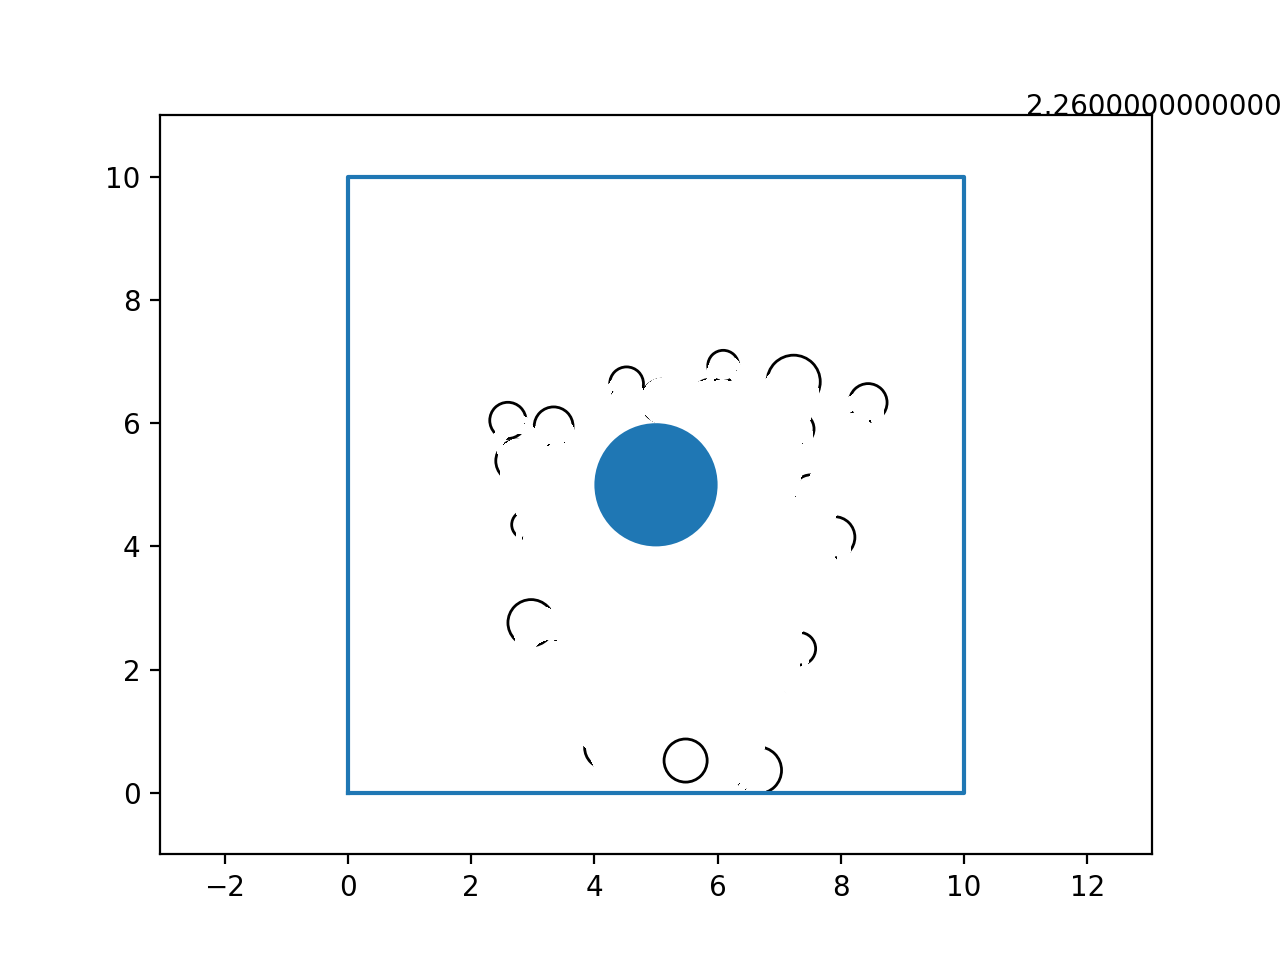

Sauvegarder animation ? y/n    n


In [21]:
%matplotlib notebook
#Représentation graphique

#Transfert du fichier position en un tableau
tab_pos , tab_vitesse = readfile()

#Définition de la figure
fig, ax = plt.subplots()
fig.set_sizes=(10,10)

#Visualisation des murs
M=[0,10,10,0,0] ; N =[0,0,10,10,0]

#Définition de l'axe
ax.axis('equal')
ax.set(xlim=(-1, 11), ylim=(-1, 11))

L=[]
for i in range(p):
    s=str(i*dt)
    L=L+[plt.text(11,11,s)]
    Artist.set_visible(L[i], False)

#Fonction d'initialisation
def init():
    pass
    return

#Plot de la figure
plt.plot(M,N)

#Animation
ani = anim.FuncAnimation(fig, animate, frames=p, init_func= init, blit=False,save_count=p, 
                             interval=100, repeat=False , fargs = (tab_pos,ax,R,n_liste,L,n_obstacle))

#Sauvegarde de l'animation en fichier .mp4
ans_user = input('Sauvegarder animation ? y/n    ')
if ans_user == 'y':
    Writer = anim.writers['ffmpeg']
    writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
    ani.save('simulation.mp4', writer=writer)
